In [1]:
import os
import sys

import pandas as pd

## First let's look at our dataset and determine how it should be split up

In [4]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [2]:
## Let's make a directory within datasets to store all our files
# Choose a short string 3-5 characters to denote this particular dataset
# For this one, I chose "ribo" for the ribosomal rna.
# Make sure to set "focus" in datatype as the same string

dataset_focus = "cov"
dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [3]:
# Let's import our data_prep tools
import data_prep as dp

In [7]:
# The below code can take awhile to run depending on the size of each file
cov_df = dp.process_raw_fasta_files("r1.txt", "r2.txt", "r3.txt", "r4.txt", "r5.txt", "r6.txt", "r7.txt", "r8.txt", "r9.txt", "r10.txt", "r11.txt", "r12.txt", in_dir="/mnt/D1/sars-cov-2-data/processed/", out_dir=dataset_dir, violin_out="cov_data_lengths", input_format="fasta")

Observed Characters: ['C', 'A', 'N', 'G', 'T']


## Looking at the above graph + the length report in our out directory we see this

<img src="./cov/cov_data_lengths.png" alt="COV Data Lengths" style="height: 50px; width:50px;"/>

In [3]:
!cat ./cov/r5_len_report.txt

Removed 3036794 Repeat Sequences
Length: 19 Number of Sequences 1
Length: 25 Number of Sequences 2
Length: 27 Number of Sequences 2
Length: 28 Number of Sequences 2
Length: 29 Number of Sequences 6
Length: 30 Number of Sequences 29
Length: 31 Number of Sequences 59
Length: 32 Number of Sequences 74
Length: 33 Number of Sequences 108
Length: 34 Number of Sequences 125
Length: 35 Number of Sequences 286
Length: 36 Number of Sequences 546
Length: 37 Number of Sequences 1280
Length: 38 Number of Sequences 5464
Length: 39 Number of Sequences 12615
Length: 40 Number of Sequences 2078863
Length: 41 Number of Sequences 162432


In [ ]:
# So now we can define our datatype

# Datatype defines the basics of our data, Each datatype is specified for a group of related fasta files
# Focus - > short string specifier that gives the overall dataset we are using
# Molecule -> What kind of sequence data? currently protein, dna, and rna are supported
# id -> short string specifier ONLY for datasets which have different clustering methods (CLUSTERS ONLY)
# process -> How were the gaps added to each dataset, used to name directory (CLUSTERS ONLY)
# clusters -> How many clusters are in each data file (1 if no clusters)
# cluster_indices -> Define the lengths of data put in each cluster, It is inclusive so [12, 16] includes length 12 and length 16. There must be cluster_indices for each cluster
# gap_position_indices -> Index where gaps should be added to each sequence that is short of the maximum length. (-1 means add gaps to the end of the clusters)

cov_datatype = {"focus": "cov", "molecule": "dna", "id": None, "process": None, "clusters": 1, "gap_position_indices": [-1], "cluster_indices": [[40, 40]]}

## Before we do anything else, we need to copy our datatype to phage_display_ML/rbm_torch/global_info.py
## Also make sure to add the new datatype to the datatype_list in the same file.

## Next we need to process the raw files and make our own fasta files with our preferred formatting

In [7]:
# chars_to_remove = ["W", "D", "V", "M", "B", "R", "K", "Y", "H", "S"]
# chars_replace = {x: "-" for x in chars_to_remove}
dp.prepare_data_files("cov", cov_df, target_dir=dataset_dir, character_conversion={"T": "U", "N":"-"}, remove_chars=None) # Creates datafiles in target directory

## Now we have generated a data file that we can use for training our RBM or CRBM

#We will also try scaling the weights based off other information. In this case I am going choose a weight that is representative of both the copy number and the number of sequences that match with less than a threshold of difference b/t one another. To do this I'm going to read in the already processed files with their count number. And write them out with the altered weights in the fasta file

In [ ]:
import numpy as np

#### The Below Scaling Weights didn't work too well, returned about the same model as just the raw weights

In [ ]:
## Scaling all Rounds except R1 and R2 (way too much data, pairwise neighbor jobs aren't done yet)

In [3]:
fasta_file = "r3.fasta"
dp.scale_weights(f"./cov/{fasta_file}", "./cov/sw/", f"./cov/{fasta_file}_15_neighbor_counts.pkl", molecule="dna", threads=12, precision=20, scale_log=True, copynum_coeff=5.0, neighbor_coeff=0.5, normalize_threshold=0.75)

Process Time 0.587090015411377


In [4]:
sys.path.append("../rbm_torch/")
import rbm_torch.utils as utils
import data_prep as dp
import numpy as np

In [5]:
all_fasta_files = [f"r{i}.fasta" for i in range(3, 13)]
all_affinities =[]
min_vals = []
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
    # stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/sw/{fasta_file.split('.')[0]}_stand_affs")
    stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_stand_affs")
    min_vals.append(min(stand_affs))
    all_affinities.append(stand_affs)
    # neighs = dp.load_neighbor_file(f"./cov/{fasta_file}_15_neighbor_counts.pkl")
    # neighs_log_scaled = dp.scale_values_np(dp.log_scale(neighs, base=0.001), min=0.01, max=1.00)
    # dp.quick_hist(neighs_log_scaled.squeeze(1).tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_neighs_log_scaled")
    # new_weights = np.asarray(stand_affs) * neighs_log_scaled.squeeze(1)
    # dp.quick_hist(new_weights.tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_aff_and_neigh_weights")
    # dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_nw_weights", stand_affs, "nw")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")
    # dp.write_fasta(seqs, new_weights.tolist(), f"./cov/sw/{fasta_file.split('.')[0]}_n")

Process Time 0.5592570304870605
Process Time 0.3178377151489258
Process Time 1.5709872245788574
Process Time 1.1642749309539795
Process Time 2.1850874423980713
Process Time 0.6264688968658447
Process Time 0.16741061210632324
Process Time 0.41866111755371094
Process Time 0.20952653884887695
Process Time 0.4487771987915039


In [6]:
thresholds = min_vals
for fid, fasta_file in enumerate(all_fasta_files):
    new_weights =dp.negate_affinites(all_affinities[fid], thresholds[fid], out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_n3_affs", negative_factor=10000.)
    dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_n3_weights", new_weights, "n3")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")

In [82]:
neighs = calc_neighbors(X, threshold=0.15)
o = open(f"{fasta_file}_pairwise_distances.txt", "w+")
o.write(neighs)
o.close()

0.006617928672809606 % done
0.013235857345619212 % done
0.01985378601842882 % done
0.026471714691238424 % done
0.03308964336404803 % done
0.03970757203685764 % done
0.04632550070966725 % done
0.05294342938247685 % done


KeyboardInterrupt: 

In [2]:
sys.path.append("../")
import rbm_torch.global_info as gi

In [12]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [4]:
gi.generate_dataset_file([f"r{i}.fasta" for i in range(1, 13)], gi.supported_datatypes["cov"], destination="./dataset_files/")

In [1]:
!cat "./dataset_files/cov.json"

{"data_files": {"1": ["r1.fasta", "r2.fasta", "r3.fasta", "r4.fasta", "r5.fasta", "r6.fasta", "r7.fasta", "r8.fasta", "r9.fasta", "r10.fasta", "r11.fasta", "r12.fasta"]}, "rounds": {"1": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}, "model_names": {"1": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}, "local_model_dir": {"rbm": "/mnt/D1/globus/cov_trained_rbms/", "crbm": "/mnt/D1/globus/cov_trained_crbms/"}, "data_dir": "../../datasets/cov/", "server_model_dir": {"rbm": "datasets/cov/trained_rbms/", "crbm": "datasets/cov/trained_crbms/"}, "molecule": "dna", "configkey": {"1": "cov"}, "clusters": 1}

In [ ]:
# We're all set to run our models now, except for creating default configs for each dataset
# Here is an example one for crbm. It should be appended to crbm_configs.py and added to all_configs dictionary also in crbm_configs.py

thc_default_config = {"fasta_file": "",
          "v_num": 43,
          "q": 5,
          "molecule": "rna",
          "epochs": 100, # get's overwritten by training script anyway
          "seed": seed, # this is defined in the config file
          "batch_size": 10000, # can be raised or lowered depending on memory usage
          "mc_moves": 4,
          "lr": 0.006,
          "lr_final": None, # automatically set as lr * 1e-2
          "decay_after": 0.75,
          "loss_type": "free_energy",
          "sample_type": "gibbs",
          "sequence_weights": None,
          "optimizer": "AdamW",
          "weight_decay": 0.001,  # l2 norm on all parameters
          "l1_2": 25.0,
          "lf": 5.0,
          "ld": 10.0,
          "data_worker_num": 4
          }


In [1]:
# TO figure out the convolution topology we use some helper functions in crbm.py

# This function gives all convolutions that fully sample all visible units on the conv transpose for a given data size
from rbm_torch.utils import suggest_conv_size

# one hot encoded vector of input size (B x V X Q) is the input the CRBM uses
visible_num = 43 # V
q_states = 5 #Q
input_shape = (visible_num, q_states)
suggest_conv_size(input_shape, padding_max=2, dilation_max=1, stride_max=2)

Finding Whole Convolutions for Input with 43 inputs:
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found:

## My current line of thinking is that having a dilation > 1 or a stride > 1 will introduce some position specific effects.

In [ ]:
## Idea: The size of the kernel controls defines the size of the motif/pattern of the convolutional filter. So for this dataset I expect long filters to capture the secondary structure of this rfam family

# It is possible to use different strides and dilations, but I think they only take away from the interpretability of the convolutional filters. Also, they can lead to unsampled visible units on the convolution transpose. Likewise using a hidden layer with the kernel size the same as the number of visible units is somewhat equivalent to an RBM if not exactly (I haven't verified). This introduces a positional dependence into the corresponding hidden layer of the model.

# So I will use sizes:  11, 25, 46, 86, 100, 112
# Motif Finding:  Local Features-------Global Features
# Names/Keys for hidden layers in the convolutional topology can be named anything you can use as key in a dictionary
# Model outputs are the average of each hidden layer with a set weight
thc_default_config["convolution_topology"] = {"hidden10": {"number": 15, "kernel": (9, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden25": {"number": 15, "kernel": (17, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden46": {"number": 15, "kernel": (25, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden86": {"number": 15, "kernel": (33, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                             }

In [ ]:
### COPY THE ABOVE CELL TO CRBM CONFIGS AS WELL

In [ ]:
# Lets create a submission script for a slurm system to run by using the script submit.py

# Submission files are stored in rbm_torch/submission/

# From Directory rbm_torch I ran
"python submit.py -d cov -r all -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 --precision double"

# Use python submit.py -h for help!

In [2]:
# Merging rounds

import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

cov_df = am.fetch_data(["r10", "r11", "r12"], dir="./cov/", threads=6, molecule="dna")

cov_ct = dp.copynum_topology_faster(cov_df, ["r10", "r11", "r12"], threads_per_task=3)
# cov_ct.to_csv("./cov/cov_10_to_12_ct.csv", index=False)

Process Time 0.549140214920044
Process Time 0.2518928050994873
Process Time 0.5835025310516357


KeyboardInterrupt: 

In [3]:
cov_ct.head()

,sequence,r10,r11,r12
0,GGGATATTCGTCCGGGGGGGGGGCCGGGGTTCGGGGTCGT,1.0,NaN,2.0
1,GGTGGGGGGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,26.0,21.0,20.0
2,GGGGGGGCGCCCCCCCGGTTCTCGCTGCTGGTTTTGGTGC,5.0,1.0,3.0
3,CGGGTTTCCGTCTGGGGGGGGGGCCGGGGTGGGGGGTCGT,1.0,1.0,2.0
4,TCGCGGGGGGCGAGTCGGGTGCTCGTTCGAGGGGTCACAG,34.0,11.0,18.0


In [4]:
import pandas as pd
import numpy as np
cov_ct = pd.read_csv("./cov/cov_10_to_12_ct.csv")
cov_ct["mean"] = cov_ct.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)
cov_ct["max"] = cov_ct.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)

In [11]:
ones = cov_ct[cov_ct["mean"] >= 2.0]
max = cov_ct[cov_ct["max"] >= 15.0]
ones_max = ones[ones["max"] >= 6]
print(ones.index.__len__(), ones_max.index.__len__(), max.index.__len__())

94881 46632 19707


In [9]:
max.sort_values("max", ascending=False, inplace=True)
max.head(30)

<ipython-input-9-cda033640aa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max.sort_values("max", ascending=False, inplace=True)


,sequence,r10,r11,r12,mean,max
189499,GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC,1122103.0,425460.0,780426.0,775996.333333,1122103.0
142400,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT,847457.0,320078.0,555261.0,574265.333333,847457.0
39726,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT,170289.0,140742.0,650339.0,320456.666667,650339.0
175303,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,108596.0,103763.0,486834.0,233064.333333,486834.0
47658,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT,112090.0,88184.0,445204.0,215159.333333,445204.0
70642,AGGCTTATCGTCAGGGGGGTGGGTCCGGGTTCGGGGTCGT,317062.0,113679.0,261269.0,230670.000000,317062.0
56773,GCCACGCCGGCTTCGGGGGGTGGGATGGGTTCGGGGTCCT,23778.0,33603.0,220812.0,92731.000000,220812.0
182008,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAGCT,93099.0,53982.0,146539.0,97873.333333,146539.0
176095,GGGGGGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,114896.0,32291.0,90650.0,79279.000000,114896.0
156970,GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,111390.0,35664.0,90127.0,79060.333333,111390.0


In [12]:
dp.dataframe_to_fasta(max, "m1.fasta", count_key="max")

In [18]:
## Create Neighbor Job
!python ./submit_neighbor_job.py -h

usage: submit_neighbor_job.py [-h] -d DATADIR -f FASTAFILE [FASTAFILE ...] -m
                              MOLECULE -o OUT -t1 T1 -t2 T2 [-c [C]]

Generate Slurm Files for pytorch RBM and CRBM

optional arguments:
  -h, --help            show this help message and exit
  -c [C]                Number of CPU cores to use. Default is 6.

required named arguments:
  -d DATADIR, --datadir DATADIR
                        directory of fasta file
  -f FASTAFILE [FASTAFILE ...], --fastafile FASTAFILE [FASTAFILE ...]
                        fasta file
  -m MOLECULE, --molecule MOLECULE
                        Which molecule?
  -o OUT, --out OUT     File Name for generated sbatch file
  -t1 T1                1st threshold value
  -t2 T2                2nd threshold value


In [20]:
# length of seqs is 40 nucleotides on avg. SO threshold values correspond to 2 mutations away and 4 mutations away
!python ./submit_neighbor_job.py -d cov -f m1.fasta -m dna -o cov_m1_neigh -t1 0.05 -t2 0.10 -c 24

In [5]:
m1_neighs = dp.load_neighbor_file("./cov/m1.fasta_5_neighbor_counts.pkl")

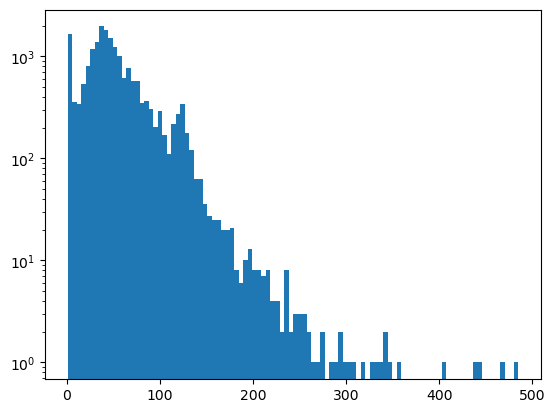

In [6]:
dp.quick_hist(m1_neighs)

Process Time 0.02819538116455078


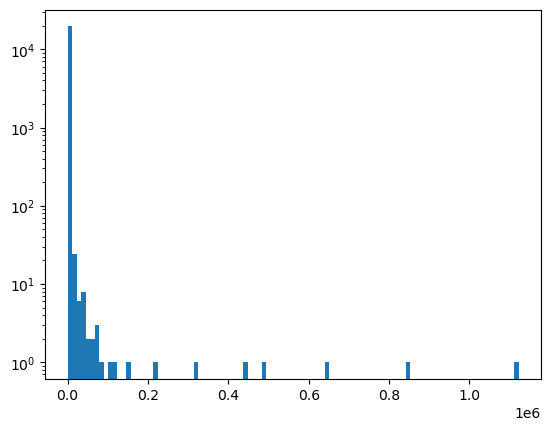

In [7]:
import rbm_torch.utils.utils as utils

seqs, affs, chars, q  = utils.fasta_read("./cov/m1.fasta", "dna", threads=6)
dp.quick_hist(affs)

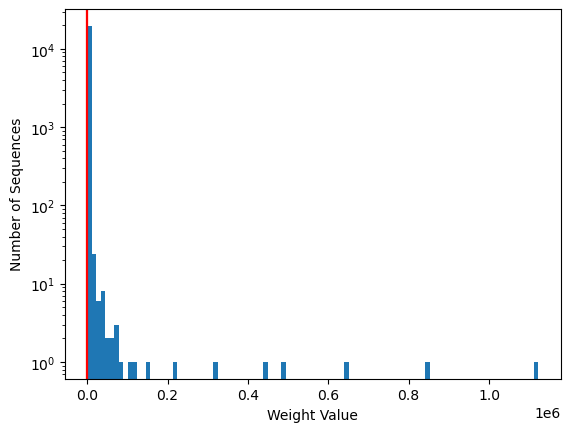

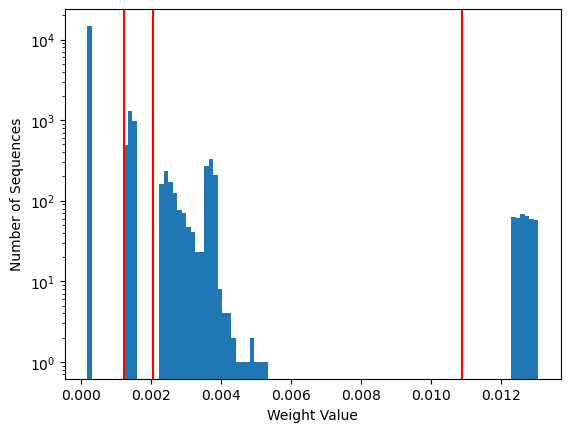

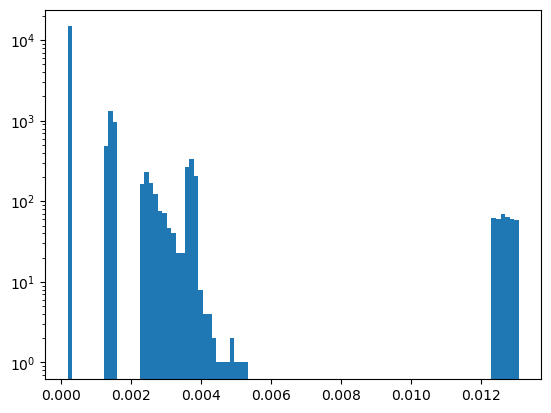

In [10]:
naffs = dp.standardize_affinities(affs, out_plots="./cov/m1_stand", scale="log", dividers=[5, 15, 25], target_scaling=[1.2, 1.2, 1.2], divider_type="percentile")
dp.quick_hist(naffs)

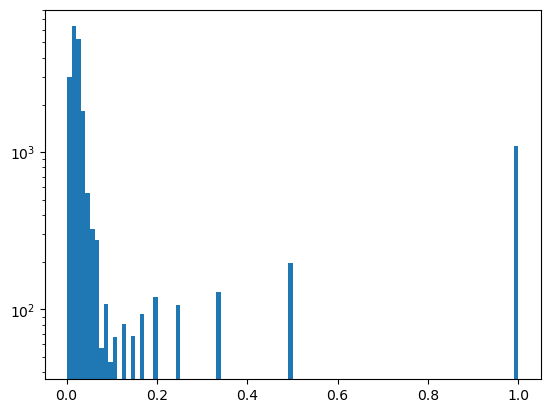

In [12]:
inverse_m1_neighs = [1/x for x in m1_neighs]
dp.quick_hist(inverse_m1_neighs)

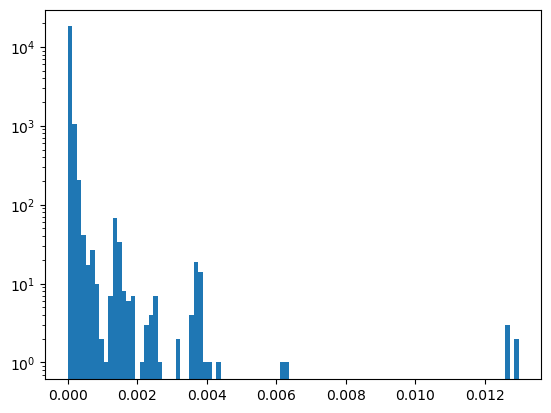

In [14]:
test_scaling = [naffs[xid]* x for xid, x in enumerate(inverse_m1_neighs)]
dp.quick_hist(test_scaling)

In [15]:
dp.make_weight_file("m1_co", test_scaling, "co", dir="./cov/")

In [16]:
import subprocess as sp
os.chdir("../rbm_torch/")


FileNotFoundError: [Errno 2] No such file or directory: 'python submit.py -h'

In [24]:
os.getcwd()
!python submit.py -h

usage: submit.py [-h] -d DATATYPE -r ROUND -p PARTITION -q QUEUE -m MODEL -e
                 EPOCHS -g GPUS [--wdir [WDIR]] [--precision PRECISION]
                 [-c [C]] [-w [W]] [--walltime [WALLTIME]] [-a [ACCOUNT]]
                 [--email [EMAIL]] [--error [ERROR]]

Generate Slurm Files for pytorch RBM and CRBM

optional arguments:
  -h, --help            show this help message and exit
  --wdir [WDIR]         Manually Set working directory, Usually handled
                        internally.
  --precision PRECISION
                        Set precision of the model, single or double
  -c [C]                Number of CPU cores to use. Default is 6.
  -w [W]                Weight File name to use to weight model training. Must
                        be in same directory as the sequence files.
                        Alternatively can be 'fasta' or None
  --walltime [WALLTIME]
                        Set wall time for training
  -a [ACCOUNT], --account [ACCOUNT]
              

In [ ]:
# I manually added m1.fasta to the dataset file
# Also manually copied weight file to the server

In [25]:
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2", shell=True) # no weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w m1_co.json", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1", shell=True) # no weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1 -w m1_co.json", shell=True) # weights

0

## The Neighbor Reweighting did not help, the model still overfit to a particular sequence motif.

In [10]:
################## Neighbor Only Reweighting
import numpy as np
m1_close_neighs = dp.load_neighbor_file("./cov/m1.fasta_5_neighbor_counts.pkl")
m1_far_neighs = dp.load_neighbor_file("./cov/m1.fasta_10_neighbor_counts.pkl")

neigh_avg = np.asarray(m1_close_neighs)+np.asarray(m1_far_neighs)/2

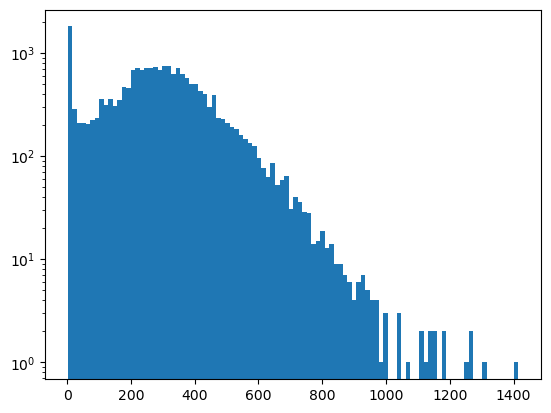

In [11]:
dp.quick_hist(neigh_avg)

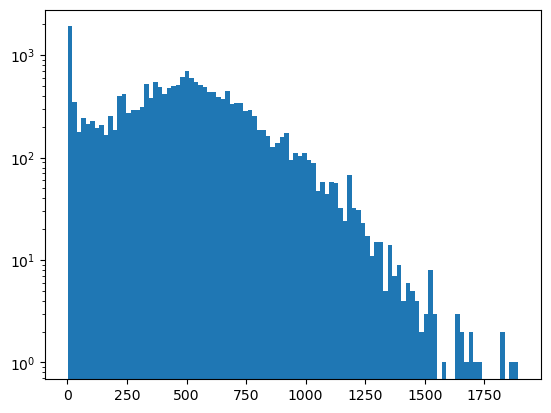

In [8]:
dp.quick_hist(m1_far_neighs)

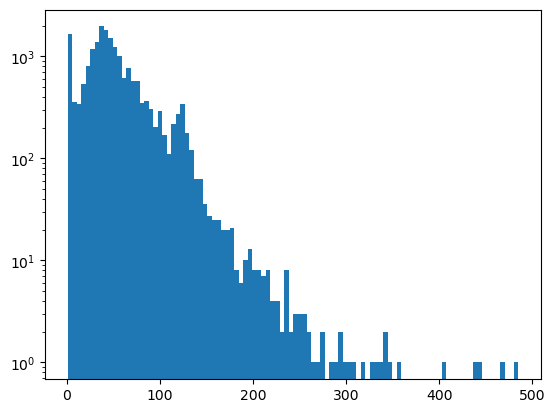

In [9]:
dp.quick_hist(m1_close_neighs)

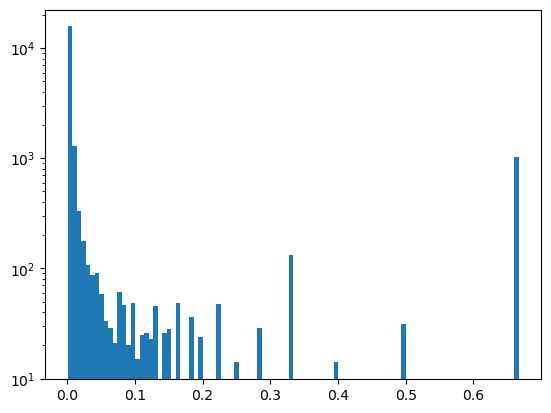

In [12]:
dp.quick_hist(1/neigh_avg)

In [14]:
dp.make_weight_file("m1_ne", (1/neigh_avg).tolist(), "ne", dir="./cov/")

In [17]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w m1_ne.json", shell=True) # weights

0

## After Separating based off PCA/kmeans, I am now training models on the individual clusters picked out from there

In [21]:
os.chdir("../datasets/")

Process Time 0.0038704872131347656


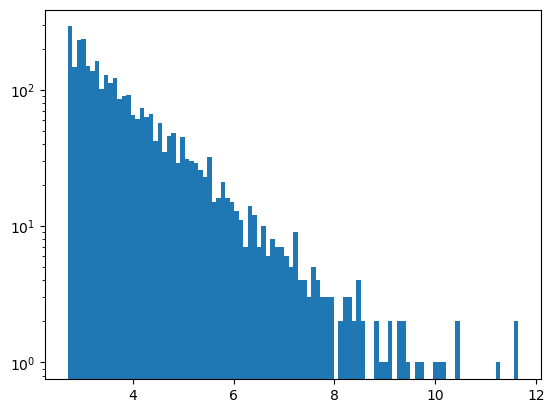

Process Time 0.006558895111083984


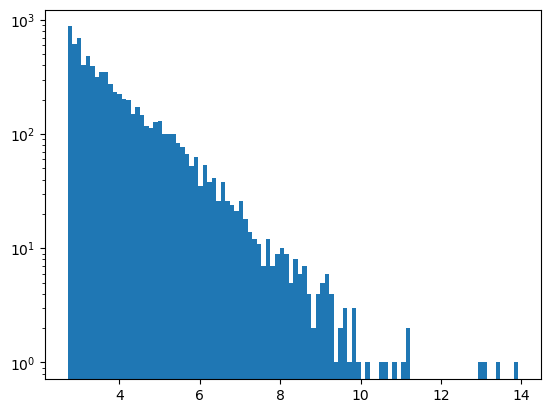

Process Time 0.00397801399230957


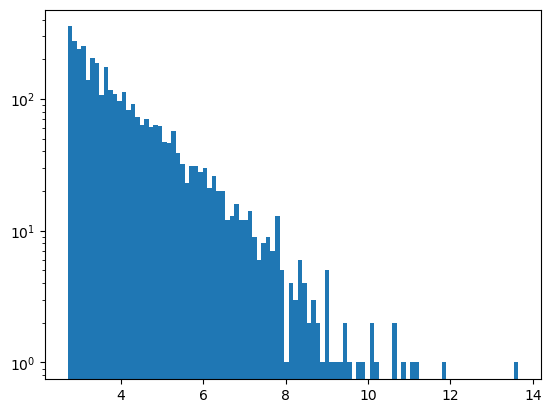

Process Time 0.004990816116333008


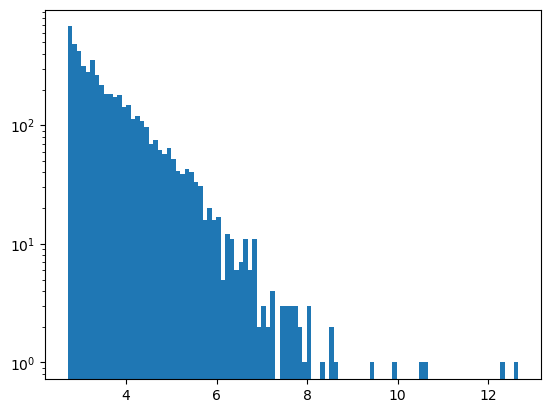

In [23]:
## Weighting by affinity for each of these files
import rbm_torch.utils.utils as utils

all_fasta_files = [f"m1_s{i}.fasta" for i in range(1, 5)]
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
    naffs = dp.log_scale(affs, base=0.001)
    # naffs = dp.standardize_affinities(affs, scale="log", dividers=[40, 70], target_scaling=[2., 1.5])
    dp.quick_hist(naffs)
    dp.make_weight_file(f"{fasta_file.split('.')[0]}_sw", naffs.tolist(), "sw", dir="./cov/")

In [25]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/rbm_torch'

In [27]:
import subprocess as sp
import os
# os.chdir("../rbm_torch/")
fasta_base = [f"m1_s{i}" for i in range(1, 5)]
weight_files = [f"m1_s{i}_sw.json" for i in range(1, 5)]
for fid, f in enumerate(fasta_base):
    sp.check_call(f"python submit.py -d cov -r {f} -p wzhengpu1 -q wildfire -m crbm -e 200 -g 1 -w {weight_files[fid]} --precision single", shell=True) # weights

In [4]:
########## Make an m1c file (Smaller subset than the m1 file)
os.chdir("../rbm_torch/")
import rbm_torch.analysis.analysis_methods as am
os.chdir("../datasets/")
m1_data = am.fetch_data(["m1"], dir="./cov/", threads=12, molecule="dna")

Process Time 0.01757359504699707


In [9]:
from copy import copy
m1c_data = copy(m1_data[m1_data["copy_num"] >= 200])  #.index.__len__()  # 2136 seqs.

import data_prep as dp
dp.dataframe_to_fasta(m1c_data, "./cov/m1c.fasta")

In [20]:
import numpy as np
import math
from rbm_torch.utils import utils


# fasta_files = ["m1c.fasta", "m1.fasta"]
fasta_ids = ["m1c", "m1"]

for fasta_id in fasta_ids:
    close_neighs = dp.load_neighbor_file(f"./cov/{fasta_id + '.fasta'}_10_neighbor_counts.pkl")
    far_neighs = dp.load_neighbor_file(f"./cov/{fasta_id + '.fasta'}_20_neighbor_counts.pkl")

    neigh_avg = (np.asarray(close_neighs)+np.asarray(far_neighs))/2
    neigh_vals = 1. + 1./neigh_avg
    neigh_exp_vals = np.exp(neigh_vals) - math.e


    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)
    if fasta_id == "m1c":
        stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st", scale="log", dividers=[70], target_scaling=[2.], divider_type="percentile")
    elif fasta_id == "m1":
        stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st", scale="log", dividers=[70], target_scaling=[2.], divider_type="percentile")


    dp.make_weight_file(f"{fasta_id}_nexp", neigh_exp_vals.tolist(), "nexp", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_ne", neigh_vals.tolist(), "ne", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_st", neigh_vals.tolist(), "st", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_stne", (neigh_vals*stand_affs).tolist(), "stne", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_stnexp", (neigh_exp_vals*stand_affs).tolist(), "stnexp", dir="./cov/")

Process Time 0.0036449432373046875
Process Time 0.015247106552124023


In [22]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_nexp.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_ne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_st.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_stne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_stnexp.json --precision single", shell=True) # weights

sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_nexp.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_ne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_st.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_stne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_stnexp.json --precision single", shell=True) # weights

0

## Now Trying a DBScan approach to fixing the imbalanced neighbors

In [ ]:
### Some crap I had to write to fix an import problem
import os
os.chdir("../rbm_torch/")
import rbm_torch.analysis.analysis_methods as am
os.chdir("../datasets/")

Process Time 0.016916751861572266


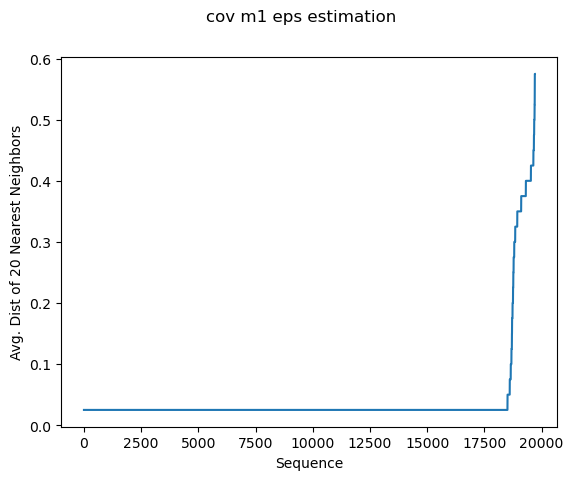

In [3]:
fasta_ids = ["m1c", "m1"]
from rbm_torch.utils import utils
import data_prep as dp
import rbm_torch.analysis.clustering_methods as cm

fasta_id = "m1"

seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)
cat = utils.seq_to_cat(seqs, molecule="dna")

cm.estimate_dbscan_eps(cat, nn=20, title="cov m1 eps estimation")

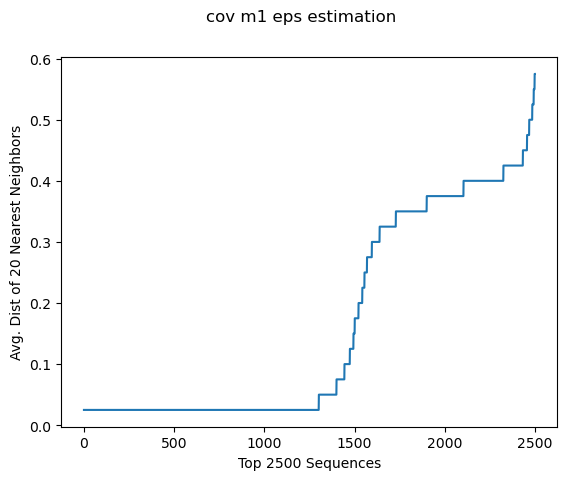

In [4]:
cm.estimate_dbscan_eps(cat, nn=20, top_dists=2500, title="cov m1 eps estimation")

In [5]:
# Estimating off the above graph, we are going to run dbscan at an eps of 0.07 ish
# We are going to choose a minimum samples parameter of 82 as that is double the dimension of our input vectors.
# The above is based off this tutorial: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

m1_labels = cm.cluster_seqs(cat, min_samples=82, eps=0.07)

Clust 0 Length 949
Clust 1 Length 2848
Clust 2 Length 541
Clust 3 Length 2720
Clust 4 Length 3030
Clust 5 Length 1336
Clust 6 Length 1721
Clust 7 Length 105
Clust 8 Length 217
Clust 9 Length 371
Clust 10 Length 244
Clust 11 Length 263
Clust 12 Length 1526
Clust -1 Length 3836
Estimated number of clusters: 13
Estimated number of noise points: 3836


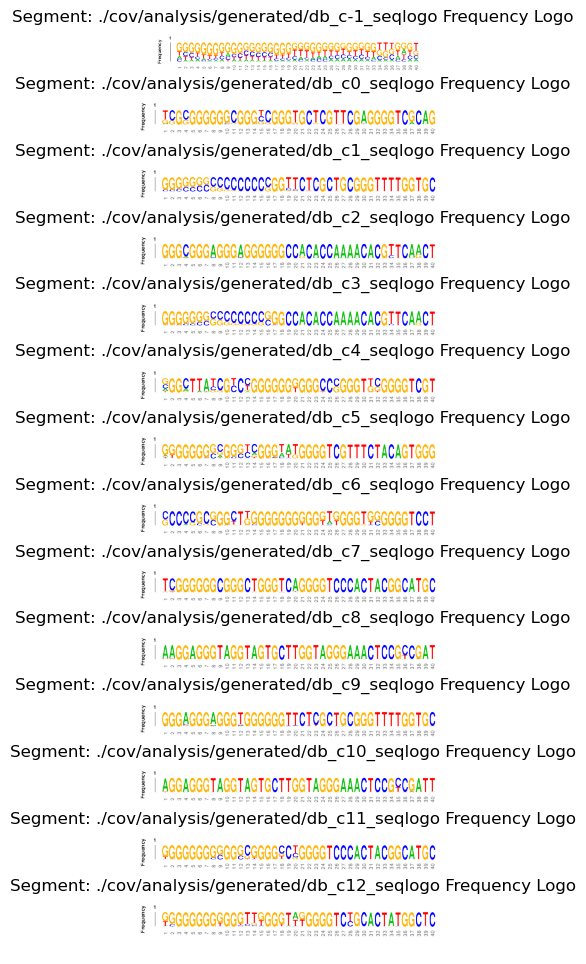

In [13]:
import pandas as pd
# import rbm_torch.analysis.analysis_methods as am
m1_df = pd.DataFrame({"sequence": seqs, "copy_num": affs, "label": m1_labels})

paths = []
cluster_id = [-1]
cluster_id += [i for i in range(13)]
for clust in cluster_id:
    paths.append(am.seq_logo(m1_df[m1_df["label"] == clust], f"db_c{clust}_seqlogo", weight=False, outdir="./cov/analysis/generated/"))

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, axs = plt.subplots(len(cluster_id), 1)
fig.set_size_inches(15, 12)

for rid, r in enumerate(paths):
    img1 = mpimg.imread(f"{r}.freq.png")
    axs[rid].imshow(img1)
    axs[rid].axis("off")
    axs[rid].set_title(f"Segment: {r} Frequency Logo")

plt.show()

In [29]:
import numpy as np
os.chdir("../datasets/")
unique, counts = np.unique(m1_labels, return_counts=True)
mapping = {x : 1./counts[xid] for xid, x in enumerate(list(unique)) if x > -1}
db_neigh_vals = [mapping[x] if x > -1 else 1. for x in list(m1_labels)]


stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st2", scale="log", dividers=[30, 70], target_scaling=[2., 2.], divider_type="percentile")

dp.make_weight_file(f"{fasta_id}_db", db_neigh_vals, "db", dir="./cov/")
dp.make_weight_file(f"{fasta_id}_st2", stand_affs, "st2", dir="./cov/")
dp.make_weight_file(f"{fasta_id}_dbst2", (np.asarray(db_neigh_vals)*stand_affs).tolist(), "dbst2", dir="./cov/")

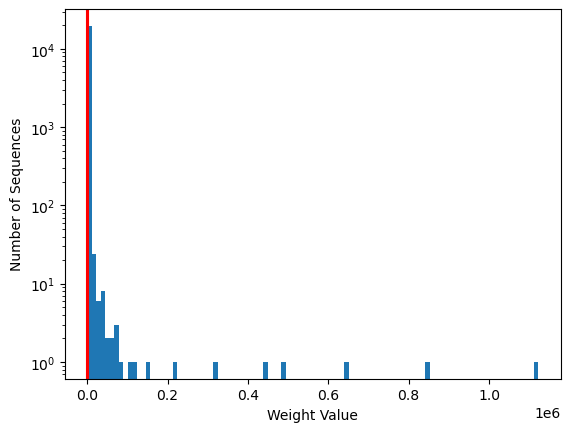

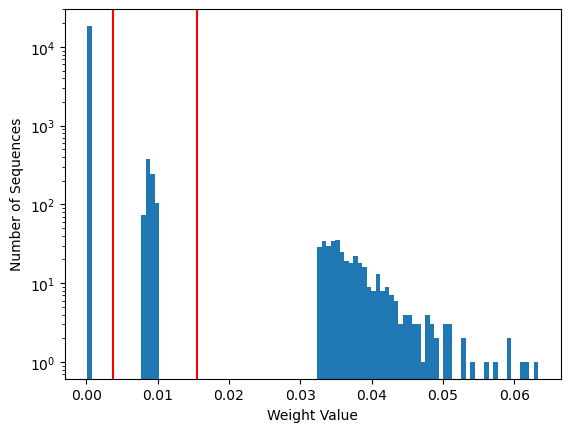

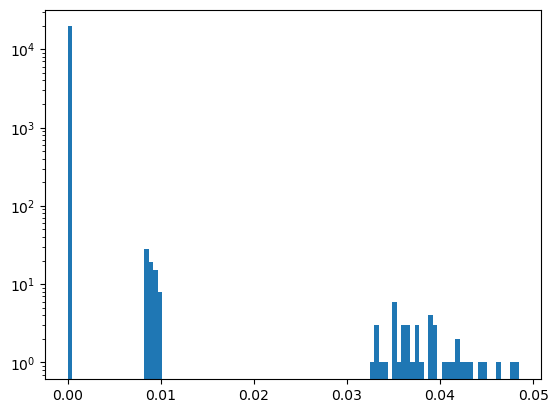

In [24]:
dp.quick_hist(np.asarray(db_neigh_vals)*stand_affs)

In [27]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_db.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_dbst2.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_st2.json --precision single", shell=True) # weights

0

In [150]:
def hierarchy_dendrogram(input):
    from matplotlib import pyplot as plt
    import scipy.cluster.hierarchy as shc
    dendro = shc.dendrogram(shc.linkage(input, method="average", metric="hamming"), leaf_font_size=2, leaf_rotation=90, labels=np.arange(0, input.shape[0], 1))
    plt.title("Dendrogram Plot")
    plt.ylabel("Hamming Distances")
    plt.xlabel("Sequences")
    plt.show()

def hierarchy_clustering(input, n_clusters, metric="euclidean"):
    from sklearn.cluster import AgglomerativeClustering
    if metric == "euclidean":
        link_age = "ward"
    else:
        link_age = "average"
    hc = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage=link_age)
    y_pred = hc.fit_predict(input)
    return y_pred

In [45]:
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as shc

link = shc.linkage(cat, method="average", metric="hamming")
# hierarchy_dendrogram(cat)

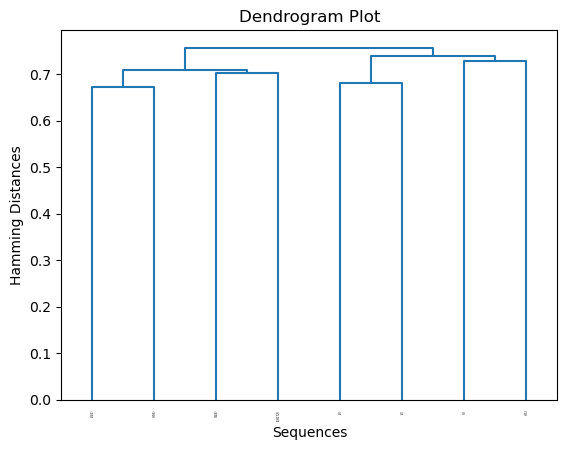

In [131]:
dendro = shc.dendrogram(link, leaf_font_size=2, leaf_rotation=90, labels=np.arange(0, cat.shape[0], 1), truncate_mode="level", p = 2)
plt.title("Dendrogram Plot")
plt.ylabel("Hamming Distances")
plt.xlabel("Sequences")
plt.show()

In [142]:
def cat_to_one_hot(cat_seqs, q):
    one_hot = np.zeros((cat_seqs.shape[0], cat_seqs.shape[1]*q))
    for i in range(cat_seqs.shape[0]):
        for j in range(cat_seqs.shape[1]):
            one_hot[i, j*q:(j+1)*q][cat_seqs[i, j]] = 1
    return one_hot

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


In [144]:
oh = cat_to_one_hot(cat, 5)

link = shc.linkage(oh, method="ward", metric="euclidean")

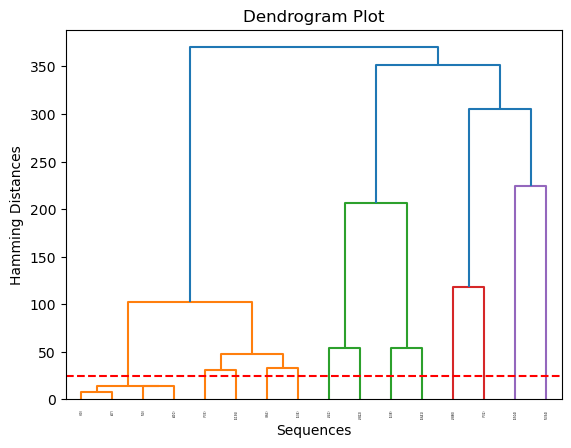

In [177]:
dendro = shc.dendrogram(link, leaf_font_size=2, leaf_rotation=90, labels=np.arange(0, cat.shape[0], 1), truncate_mode="level", p = 3)
plt.axhline(25, color="r", linestyle="dashed")
plt.title("Dendrogram Plot")
plt.ylabel("Hamming Distances")
plt.xlabel("Sequences")
plt.show()

In [172]:
clust_num = 13
hclusters = hierarchy_clustering(oh, clust_num)
m1_df["hclust"] = hclusters

In [173]:
uniq, counts = np.unique(hclusters, return_counts=True)
for vid, v in enumerate(uniq):
    print(f"Cluster {v}, counts={counts[vid]}")

Cluster 0, counts=3415
Cluster 1, counts=2870
Cluster 2, counts=1779
Cluster 3, counts=295
Cluster 4, counts=2880
Cluster 5, counts=3063
Cluster 6, counts=1565
Cluster 7, counts=968
Cluster 8, counts=411
Cluster 9, counts=1504
Cluster 10, counts=297
Cluster 11, counts=223
Cluster 12, counts=437


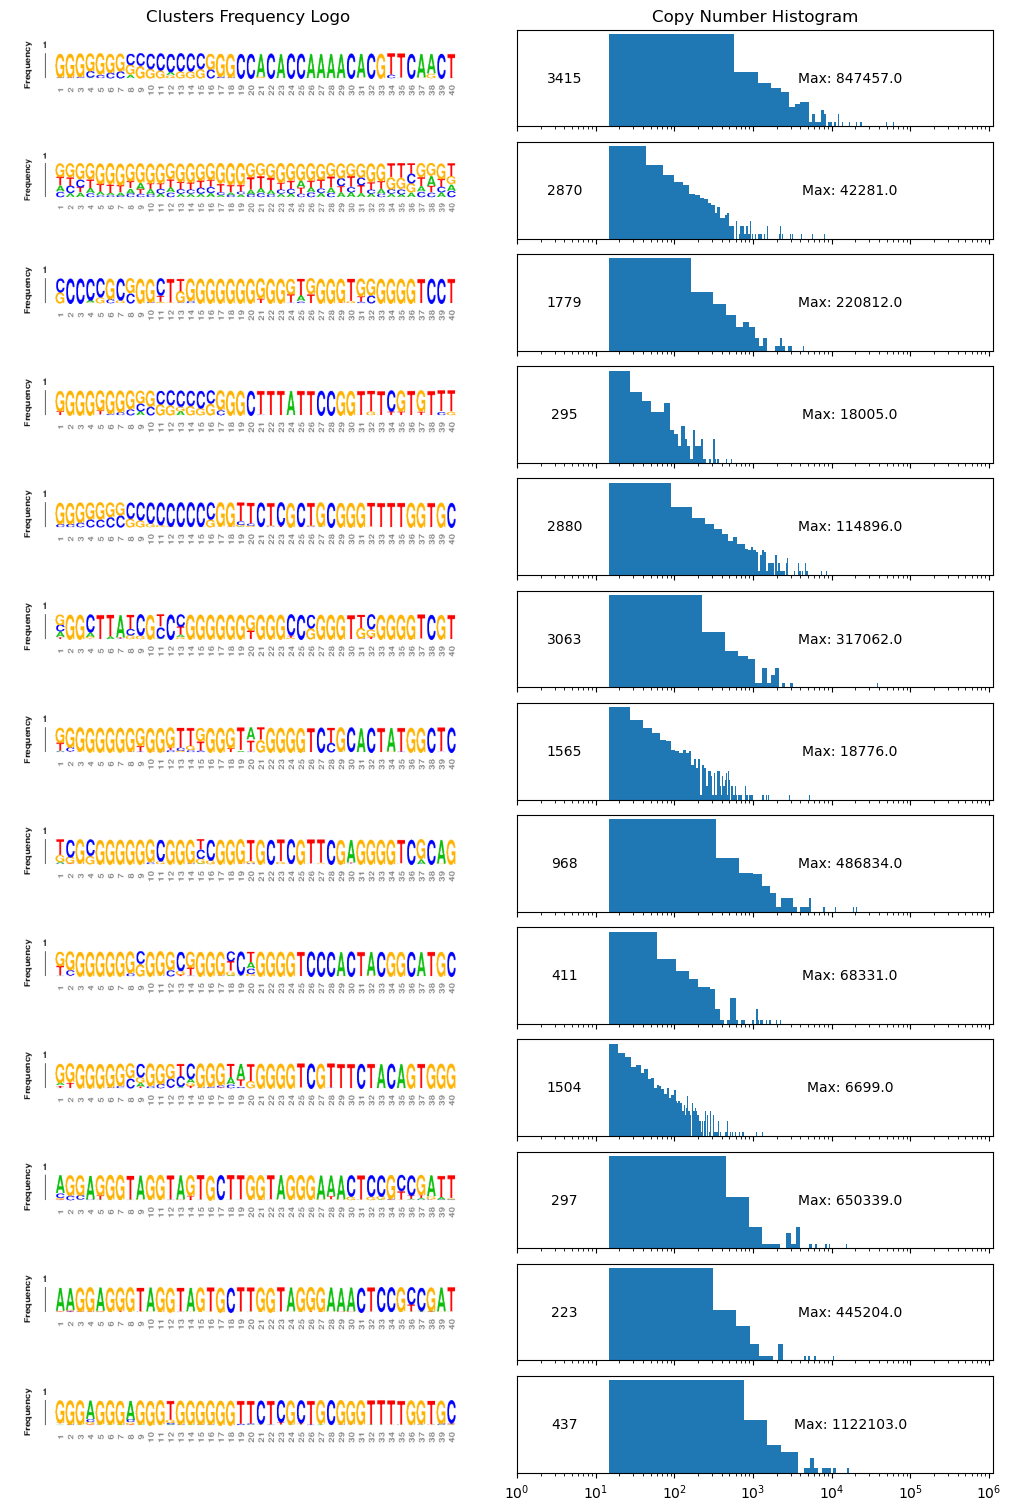

In [180]:
cluster_id = [i for i in range(clust_num)]
uniq, counts = np.unique(hclusters, return_counts=True)

paths = []
cluster_cns = []
hmin, hmax = 1, 1
for clust in cluster_id:
    # seqlogo data
    cluster_data = m1_df[m1_df["hclust"] == clust]
    paths.append(am.seq_logo(cluster_data, f"hierarchy_c{clust}_seqlogo", weight=False, outdir="./cov/analysis/generated/"))

    #copy number info
    copy_nums = cluster_data["copy_num"].tolist()
    cluster_cns.append(copy_nums)

    # min and max of the histogram plots
    cluster_min = min(copy_nums)
    cluster_max = max(copy_nums)
    if cluster_min < hmin:
        hmin = cluster_min
    if cluster_max > hmax:
        hmax = cluster_max


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 15), constrained_layout=True)
widths = [1, 1]
heights = [1 for i in range(len(cluster_id))]
spec = fig.add_gridspec(ncols=2, nrows=len(cluster_id), width_ratios=widths, height_ratios=heights)

for row in range(len(cluster_id)):
    for col in range(2):
        ax = fig.add_subplot(spec[row, col])
        if col == 0:
            img1 = mpimg.imread(f"{paths[row]}.freq.png")
            ax.imshow(img1, aspect='auto', extent=(0,60,0.0,1.5), alpha=1.0, zorder=-1)
            ax.axis("off")
            if row == 0:
                ax.set_title(f"Clusters Frequency Logo")
        elif col == 1:
            ax.hist(cluster_cns[row], bins=1500) #bins=len(cluster_cns[row])//2)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlim((hmin, hmax))
            ax.text(0.1, 0.5, f'{counts[row]}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.text(0.7, 0.5, f'Max: {max(cluster_cns[row])}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            if row == 0:
                ax.set_title(f"Copy Number Histogram")
            if row == len(cluster_id)-1:
                ax.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False,
                labelleft=False) # labels along the bottom edge are off
            else:
                ax.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False,
                labelleft=False) # labels along the bottom edge are off

plt.show()

In [199]:
#### Let's try to sample a "balanced dataset"

## First let's combine clusters that are basically the same

## Really Only clusters 10 and 11 which are basically shifted versions of one another
from copy import copy
from functools import reduce
clust_dfs = []
for i in range(clust_num):
    clust_dfs.append(copy(m1_df[m1_df["hclust"] == i]))

# indices are 10 and 11, they are cluster 11 and 12
merged_10_11 = pd.merge(clust_dfs[10], clust_dfs[11], how="outer")

# Get List
nclust_dfs = clust_dfs[:10]
nclust_dfs.append(clust_dfs[-1])
nclust_dfs.append(merged_10_11)

seq_num = 250

top_dfs = []
for iid, i in enumerate(nclust_dfs):
    i.sort_values("copy_num", ascending=False, inplace=True)
    best = i.head(seq_num)
    top_dfs.append(best)

top_df_merged = reduce(lambda  left,right: pd.merge(left,right,
                                            how='outer'), top_dfs)
print(top_df_merged.index.__len__())


3000


In [201]:
dp.dataframe_to_fasta(top_df_merged, "./cov/b1.fasta")

In [202]:
fasta_id = "b1"

seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)

stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st", scale="log", dividers=[70], target_scaling=[2.], divider_type="percentile")

dp.make_weight_file(f"{fasta_id}_st", stand_affs, "st", dir="./cov/")

Process Time 0.004328489303588867


In [203]:
import os
import subprocess as sp
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r b1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r b1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single -w b1_st.json", shell=True) # weights

0

In [205]:
os.chdir("../datasets/")

In [206]:
import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

cov_mid_2_df = am.fetch_data(["r7", "r8", "r9"], dir="./cov/", threads=12, molecule="dna")

cov_mid_2_ct = dp.copynum_topology_faster(cov_mid_2_df, ["r7", "r8", "r9"], threads_per_task=4)

Process Time 2.189279794692993
Process Time 0.6570813655853271
Process Time 0.17784500122070312
Process Time 6552.8138692379


In [207]:
import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

cov_mid_1_df = am.fetch_data(["r4", "r5", "r6"], dir="./cov/", threads=12, molecule="dna")

cov_mid_1_ct = dp.copynum_topology_faster(cov_mid_1_df, ["r4", "r5", "r6"], threads_per_task=4)

Process Time 0.35595703125
Process Time 1.5904810428619385
Process Time 1.0671017169952393
Process Time 8623.128337621689


In [208]:
cov_mid_1_ct.index.__len__()

358266

In [209]:
cov_mid_2_ct.index.__len__()

313771

In [210]:
cov_mid_2_ct.to_csv("./cov/cov_7_to_9_ct.csv", index=False)
cov_mid_1_ct.to_csv("./cov/cov_4_to_6_ct.csv", index=False)

In [213]:
from sklearn.metrics import pairwise_distances
fasta_id = "m1"
seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)

m1_df = pd.DataFrame({"sequence": seqs, "copy_num": affs})
m1_df.sort_values("copy_num", ascending=False, inplace=True)

m1_seqs = m1_df.sequence.tolist()
m1_cns = m1_df.copy_num.tolist()

cat = utils.seq_to_cat(m1_seqs, molecule="protein")

X = cat.numpy().astype(np.int8)

# X should be a categorical vector of shape (seqs, bases)
seq_len = len(m1_seqs[0])
selected_seqs, selected_cns, selected_cat = [], [], []
hamming_threshold = 3
total_seqs = len(m1_seqs)
for i in range(total_seqs):  # len(m1_seqs)
    if i == 0:
        selected_seqs.append(m1_seqs[i])
        selected_cns.append(m1_cns[i])
        selected_cat.append(X[i])
    else:
        dist_matrix = pairwise_distances([X[i]], selected_cat, metric="hamming")*seq_len
        # print(dist_matrix)
        if min(dist_matrix[0]) > hamming_threshold:
            selected_seqs.append(m1_seqs[i])
            selected_cns.append(m1_cns[i])
            selected_cat.append(X[i])

print(f"Kept {len(selected_seqs)} of {total_seqs}")

Process Time 0.015239238739013672
Kept 1633 of 19707


In [214]:
dp.write_fasta(selected_seqs, selected_cns, "./cov/h1.fasta")

In [215]:
fasta_file = "h1.fasta"

seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_file.split('.')[0]}_st", scale="log", dividers=[60], target_scaling=[2.], divider_type="percentile")

dp.make_weight_file("h1_st", stand_affs, "st", dir="./cov/")

Process Time 0.003206491470336914


In [216]:
import os
import subprocess as sp
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r h1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r h1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w h1_st.json --precision single", shell=True) # weights

0

In [217]:
chars

['T', 'C', 'A', 'G', 'N']

In [2]:
import pandas as pd
mid_pd = pd.read_csv("./cov/cov_7_to_9_ct.csv")
low_pd = pd.read_csv("./cov/cov_4_to_6_ct.csv")

In [4]:
import numpy as np

cov_ct = mid_pd
cov_ct["mean"] = cov_ct.apply(lambda row: np.nanmean(np.asarray([row[x] for x in ["r7", "r8", "r9"]])), axis=1)
cov_ct["max"] = cov_ct.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r7", "r8", "r9"]])), axis=1)


171439 95512 32898


In [17]:
ones = cov_ct[cov_ct["mean"] >= 5.0]
max = cov_ct[cov_ct["max"] >= 100.0]
print(ones.index.__len__(), max.index.__len__())

72287 7478


In [6]:
import data_prep as dp

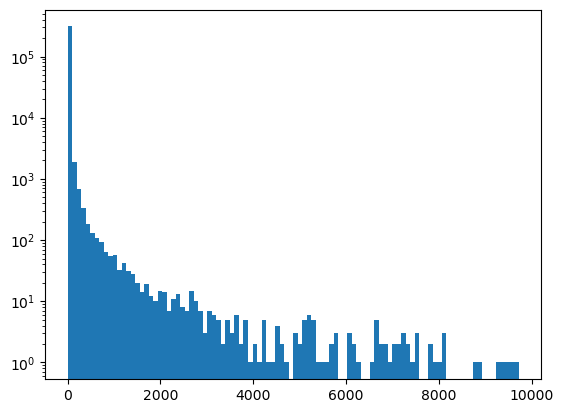

In [11]:
mean = cov_ct["mean"].tolist()
mean_adj = [x for x in mean if x < 10000]

dp.quick_hist(mean_adj)

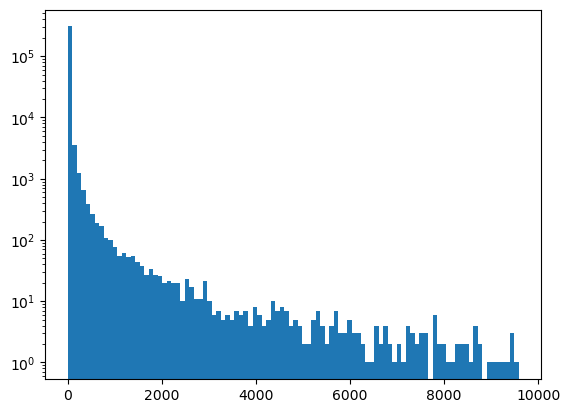

In [12]:
max = cov_ct["max"].tolist()
max_adj = [x for x in max if x < 10000]

dp.quick_hist(max_adj)

In [26]:
from sklearn.metrics import pairwise_distances
from rbm_torch.utils import utils


# m1_df = pd.DataFrame({"sequence": seqs, "copy_num": affs})


def hamming_sort(dataframe, hamming_threshold=5):

    dataframe.sort_values("copy_num", ascending=False, inplace=True)

    seqs = dataframe.sequence.tolist()
    cns = dataframe.copy_num.tolist()

    cat = utils.seq_to_cat(seqs, molecule="dna")

    X = cat.numpy().astype(np.int8)

    # X should be a categorical vector of shape (seqs, bases)
    seq_len = len(seqs[0])
    selected_seqs, selected_cns, selected_cat = [], [], []
    total_seqs = len(seqs)
    for i in range(total_seqs):  # len(m1_seqs)
        if i == 0:
            selected_seqs.append(seqs[i])
            selected_cns.append(cns[i])
            selected_cat.append(X[i])
        else:
            dist_matrix = pairwise_distances([X[i]], selected_cat, metric="hamming")*seq_len
            # print(dist_matrix)
            if min(dist_matrix[0]) > hamming_threshold:
                selected_seqs.append(seqs[i])
                selected_cns.append(cns[i])
                selected_cat.append(X[i])

    print(f"Kept {len(selected_seqs)} of {total_seqs}")

    return selected_seqs, selected_cns

In [48]:
from copy import copy
# fasta_id = "m1"
# seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)

max_ct = copy(cov_ct[cov_ct["max"] >= 50.0])
max_ct["copy_num"] = max_ct["max"]

In [49]:
seqs, cns = hamming_sort(max_ct, hamming_threshold=3)

Kept 3370 of 14120


In [53]:
dp.write_fasta(seqs, cns, "./cov/mid.fasta")

In [33]:
cov_low = low_pd
cov_low["mean"] = cov_low.apply(lambda row: np.nanmean(np.asarray([row[x] for x in ["r4", "r5", "r6"]])), axis=1)
cov_low["max"] = cov_low.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r4", "r5", "r6"]])), axis=1)

ones = cov_low[cov_low["mean"] >= 5.0]
max = cov_low[cov_low["max"] >= 100.0]
print(ones.index.__len__(), max.index.__len__())

48825 3782


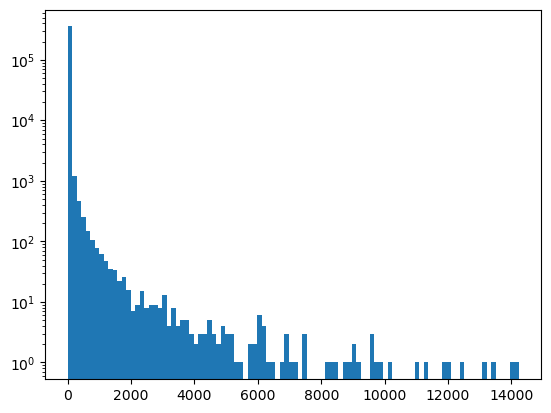

In [41]:
adj_max = [x for x in cov_low["max"].tolist() if x < 15000]
dp.quick_hist(adj_max)

In [36]:

ones = cov_low[cov_low["mean"] >= 5.0]
max = cov_low[cov_low["max"] >= 30.0]
print(ones.index.__len__(), max.index.__len__())

48825 11410


In [44]:
max_low = copy(cov_low[cov_low["max"] >= 30.0])
max_low["copy_num"] = max_low["max"]
low_seqs, low_cns = hamming_sort(max_low)

Kept 4202 of 11410


In [52]:
dp.write_fasta(low_seqs, low_cns, "./cov/low.fasta")

### Merging all sequences

In [28]:
import numpy as np
import pandas as pd
high_pd = pd.read_csv("./cov/cov_10_to_12_ct.csv")
mid_pd = pd.read_csv("./cov/cov_7_to_9_ct.csv")
low_pd = pd.read_csv("./cov/cov_4_to_6_ct.csv")

high_mid_common = pd.merge(high_pd, mid_pd, how='inner', left_on='sequence', right_on='sequence')
low_mid_common = pd.merge(low_pd, mid_pd, how='inner', left_on='sequence', right_on='sequence')
high_low_common = pd.merge(low_pd, high_pd, how='inner', left_on='sequence', right_on='sequence')

all_common = pd.merge(low_mid_common, high_pd, how='inner', left_on='sequence', right_on='sequence')

def get_len(dataframe):
    print(dataframe.index.__len__())

print("low")
get_len(low_pd)
print("mid")
get_len(mid_pd)
print("high")
get_len(high_pd)

print("low_mid_common")
get_len(low_mid_common)
print("high_low_common")
get_len(high_low_common)
print("high_mid_common")
get_len(high_mid_common)
print("all_common")
get_len(all_common)

all_seqs_pd = pd.merge(pd.merge(high_pd, mid_pd, how='outer', left_on='sequence', right_on='sequence'), low_pd, how='outer', left_on='sequence', right_on='sequence')

get_len(all_seqs_pd)

uniq = np.unique(all_seqs_pd.sequence)
print(len(uniq))

low
358266
mid
313771
high
198361
low_mid_common
91089
high_low_common
26235
high_mid_common
106970
all_common
25452
671556
671556


In [29]:
import rbm_torch.analysis.analysis_methods as am
full_data = am.fetch_data([f"r{i}" for i in range(4, 13)], dir="./cov/raw_rounds/", threads=12)

Process Time 0.5519890785217285
Process Time 1.5415129661560059
Process Time 1.030810832977295
Process Time 1.8814702033996582
Process Time 0.6228377819061279
Process Time 0.19600749015808105
Process Time 0.457683801651001
Process Time 0.215132474899292
Process Time 0.49076342582702637


In [30]:
count_millions = {}
for r in [f"r{i}" for i in range(4, 13)]:
    data = full_data[full_data["round"] == r]
    count_millions[r] = data["copy_num"].sum()/1000000

In [55]:
count_millions

{'r4': 0.72308,
 'r5': 4.831185,
 'r6': 6.586737,
 'r7': 20.863235,
 'r8': 8.589766,
 'r9': 1.989761,
 'r10': 6.868811,
 'r11': 2.893007,
 'r12': 7.957125}

In [31]:
for r in [f"r{i}" for i in range(4, 13)]:
    all_seqs_pd[r] = all_seqs_pd[r].div(count_millions[r])

In [5]:
all_seqs_pd.head()

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6
0,GGGATATTCGTCCGGGGGGGGGGCCGGGGTTCGGGGTCGT,0.145586,NaN,0.251347,0.047931,0.232835,0.502573,NaN,NaN,NaN
1,GGTGGGGGGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,3.785226,7.258883,2.513471,3.355184,4.773122,8.543740,NaN,2.276874,5.465529
2,GGGGGGGCGCCCCCCCGGTTCTCGCTGCTGGTTTTGGTGC,0.727928,0.345661,0.377021,0.335518,0.698506,0.502573,NaN,NaN,NaN
3,CGGGTTTCCGTCTGGGGGGGGGGCCGGGGTGGGGGGTCGT,0.145586,0.345661,0.251347,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGCGGGGGGCGAGTCGGGTGCTCGTTCGAGGGGTCACAG,4.949911,3.802272,2.262124,3.115528,5.937298,3.518010,NaN,0.413977,0.455461


In [40]:
# all_seqs_pd["mean"] = all_seqs_pd.apply(lambda row: np.nanmean(np.asarray([row[x] for x in ["r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]])), axis=1)
# all_seqs_pd["max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]])), axis=1)
all_seqs_pd["low_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r4", "r5", "r6"]])), axis=1)
all_seqs_pd["mid_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r7", "r8", "r9"]])), axis=1)
all_seqs_pd["high_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)
all_seqs_pd["hl_fold"] = all_seqs_pd.apply(lambda row: row["high_max"]/row["low_max"] if row["low_max"] != np.nan and row["high_max"] != np.nan else np.nan, axis=1)
all_seqs_pd["hm_fold"] = all_seqs_pd.apply(lambda row: row["high_max"]/row["mid_max"] if row["mid_max"] != np.nan and row["high_max"] != np.nan else np.nan, axis=1)
all_seqs_pd["ml_fold"] = all_seqs_pd.apply(lambda row: row["mid_max"]/row["low_max"] if row["mid_max"] != np.nan and row["low_max"] != np.nan else np.nan, axis=1)

all_seqs_pd["g_content"] = all_seqs_pd.apply(lambda row: row["sequence"].count("G"), axis=1)
all_seqs_pd["10G_strait"] = all_seqs_pd.apply(lambda row: "GGGGGGGGGG" in row["sequence"], axis=1)
all_seqs_pd["10C_strait"] = all_seqs_pd.apply(lambda row: "CCCCCCCCCC" in row["sequence"], axis=1)

<ipython-input-40-5080a71c92c1>:3: RuntimeWarning: All-NaN slice encountered
  all_seqs_pd["low_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r4", "r5", "r6"]])), axis=1)
<ipython-input-40-5080a71c92c1>:4: RuntimeWarning: All-NaN slice encountered
  all_seqs_pd["mid_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r7", "r8", "r9"]])), axis=1)
<ipython-input-40-5080a71c92c1>:5: RuntimeWarning: All-NaN slice encountered
  all_seqs_pd["high_max"] = all_seqs_pd.apply(lambda row: np.nanmax(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)


In [63]:
all_seqs_pd.sort_values("hl_fold", ascending=False, inplace=True)
all_seqs_pd.head(50)

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,mean,max,low_max,mid_max,high_max,hl_fold,hm_fold,ml_fold,g_content,10G_strait
56773,GCCACGCCGGCTTCGGGGGGTGGGATGGGTTCGGGGTCCT,3461.734498,11615.250153,27750.223856,30.580109,277.423157,958.909135,2.765946,2.690851,2.125483,4900.189243,27750.223856,2.765946,958.909135,27750.223856,10032.815933,28.939367,346.684009,20,False
103205,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT,637.082604,1955.059217,6377.303360,5.751745,44.122273,180.423679,NaN,0.413977,0.759101,1150.114495,6377.303360,0.759101,180.423679,6377.303360,8401.124001,35.346266,237.680664,16,False
188894,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGGCGATT,77.742713,322.847473,1190.002671,0.335518,4.656704,23.118354,NaN,0.206989,0.151820,202.382780,1190.002671,0.206989,23.118354,1190.002671,5749.123052,51.474367,111.689047,17,False
189639,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT,934.659579,3181.119161,9478.674773,8.963135,68.802806,257.317336,NaN,1.241931,1.821843,1741.575071,9478.674773,1.821843,257.317336,9478.674773,5202.794820,36.836518,141.240135,16,False
36655,ACTGTGGCAGCCTCTCTGGGGGGCGGGTGGTGGTGGATGG,49.644691,119.253082,668.331841,2.300698,26.193962,32.164667,NaN,0.206989,0.151820,112.280969,668.331841,0.206989,32.164667,668.331841,3228.834765,20.778447,155.393457,21,False
59650,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCAAT,152.719299,421.706550,1332.390782,1.773455,11.991013,45.734136,NaN,0.413977,0.607281,245.917062,1332.390782,0.607281,45.734136,1332.390782,2194.026915,29.133398,75.309681,15,False
44300,GCGGGGGGGGCGGGCCGGGTGCTCGTTCGAGGGGTCGCAG,143.547406,234.012569,615.548958,2.636216,26.892467,75.888511,NaN,0.206989,0.303640,137.379595,615.548958,0.303640,75.888511,615.548958,2027.229547,8.111227,249.928832,24,False
147025,TGGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,153.156056,309.712351,608.511240,2.300698,27.940226,77.898803,NaN,0.206989,0.303640,147.503750,608.511240,0.303640,77.898803,608.511240,2004.051749,7.811561,256.549464,23,False
175303,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,15810.014280,35866.833367,61182.148075,356.751961,2502.629292,5419.746392,2.765946,6.623634,37.044139,13464.950787,61182.148075,37.044139,5419.746392,61182.148075,1651.601305,11.288747,146.305099,22,False
172948,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATG,52.410818,162.460720,445.261322,0.718968,5.122375,12.564323,NaN,0.206989,0.303640,84.881144,445.261322,0.303640,12.564323,445.261322,1466.409613,35.438545,41.378946,17,False


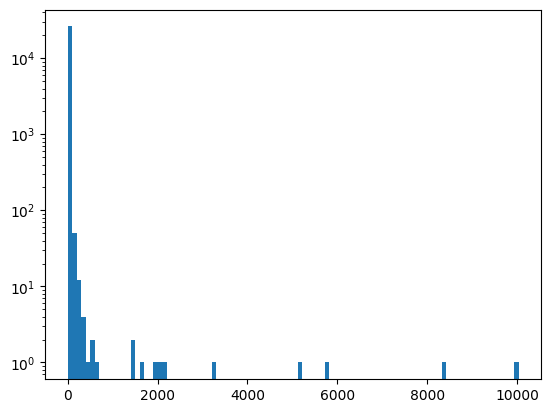

14424
11811


In [64]:
dp.quick_hist(all_seqs_pd["hl_fold"].tolist())
get_len(all_seqs_pd[all_seqs_pd["hl_fold"] >= 1.0])
get_len(all_seqs_pd[all_seqs_pd["hl_fold"] < 1.0])

In [65]:
get_len(all_seqs_pd[all_seqs_pd["ml_fold"] > 1.0])
get_len(all_seqs_pd[all_seqs_pd["ml_fold"] <= 1.0])

23854
67235


In [66]:
get_len(all_seqs_pd[all_seqs_pd["hm_fold"] > 1.0])
get_len(all_seqs_pd[all_seqs_pd["hm_fold"] <= 1.0])

53725
53245


In [45]:
from copy import copy
# enriched from mid to late rounds or early to late rounds. Must also have g_content less than 28
e1 = all_seqs_pd[((all_seqs_pd["hl_fold"] > 2.0) | (all_seqs_pd["hm_fold"] > 1.0)) & (all_seqs_pd["g_content"] <= 28) & (all_seqs_pd["10G_strait"] == False) & (all_seqs_pd["10C_strait"] == False)]
e2 = e1[(e1["hl_fold"] > 2) | (np.isnan(e1["hl_fold"])) & (e1["hm_fold"] > 1) | (np.isnan(e1["hm_fold"]))]
enriched_seqs = copy(e2)

from rbm_torch.utils.seq_utils import prune_similar_sequences

enriched_seqs["fold"] = enriched_seqs.apply(lambda row: np.nanmax(np.asarray([row["hl_fold"]/2, row["hm_fold"]])), axis=1)
enriched_seqs.sort_values("fold", ascending=False, inplace=True)
enriched_trimmed = prune_similar_sequences(enriched_seqs, hamming_threshold=4, molecule="dna")

Kept 1643 of 33052


In [47]:
enriched_trimmed = prune_similar_sequences(enriched_seqs, hamming_threshold=3, molecule="dna")

Kept 2535 of 33052


In [48]:
enriched_trimmed.head(500)

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,low_max,mid_max,high_max,hl_fold,hm_fold,ml_fold,g_content,10G_strait,10C_strait,fold
0,GCCACGCCGGCTTCGGGGGGTGGGATGGGTTCGGGGTCCT,3461.734498,11615.250153,27750.223856,30.580109,277.423157,958.909135,2.765946,2.690851,2.125483,2.765946,958.909135,27750.223856,10032.815933,28.939367,346.684009,20,False,False,5016.407966
1,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT,637.082604,1955.059217,6377.303360,5.751745,44.122273,180.423679,NaN,0.413977,0.759101,0.759101,180.423679,6377.303360,8401.124001,35.346266,237.680664,16,False,False,4200.562000
2,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGGCGATT,77.742713,322.847473,1190.002671,0.335518,4.656704,23.118354,NaN,0.206989,0.151820,0.206989,23.118354,1190.002671,5749.123052,51.474367,111.689047,17,False,False,2874.561526
3,ACTGTGGCAGCCTCTCTGGGGGGCGGGTGGTGGTGGATGG,49.644691,119.253082,668.331841,2.300698,26.193962,32.164667,NaN,0.206989,0.151820,0.206989,32.164667,668.331841,3228.834765,20.778447,155.393457,21,False,False,1614.417383
4,GCGGGGGGGGCGGGCCGGGTGCTCGTTCGAGGGGTCGCAG,143.547406,234.012569,615.548958,2.636216,26.892467,75.888511,NaN,0.206989,0.303640,0.303640,75.888511,615.548958,2027.229547,8.111227,249.928832,24,False,False,1013.614774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,GCACAGGAGGAAAGCAGCCACTGTAAGCACACCCGCCTAT,0.436757,0.691322,0.251347,0.095862,0.116418,NaN,NaN,NaN,NaN,NaN,0.116418,0.691322,NaN,5.938296,NaN,10,False,False,5.938296
496,GGGGCGGGCGGCCGGCGGCCACACCAAAACACGTTCAACT,0.145586,0.691322,0.251347,0.047931,0.116418,NaN,NaN,NaN,NaN,NaN,0.116418,0.691322,NaN,5.938296,NaN,14,False,False,5.938296
497,GGGGGTGGGGGGTTTGGTTATGGGGTCTGCACTATGGCTC,0.145586,0.691322,NaN,0.047931,0.116418,NaN,NaN,NaN,NaN,NaN,0.116418,0.691322,NaN,5.938296,NaN,20,False,False,5.938296
498,GGGCGGGGGGGCCCCGGGGTCTCGCTGCGGGTTTTGGTGC,NaN,0.691322,0.251347,0.047931,0.116418,NaN,NaN,NaN,NaN,NaN,0.116418,0.691322,NaN,5.938296,NaN,22,False,False,5.938296


In [49]:
from rbm_torch.utils import data_prep as dp
dp.dataframe_to_fasta(enriched_trimmed, "./cov/enriched2.fasta", count_key="fold")
# enriched -> 60.5k hamming trimmmed at 4 to ~2500seqs
# enriched2 -> 33.5k (hl > 2) (hm > 1) (10G straits removed) (10C straits removed) hamming trimmed at 3 to ~2500 seqs

In [7]:
ue1 = all_seqs_pd[(((all_seqs_pd["hl_fold"] < 1.0) | (all_seqs_pd["hm_fold"] < 1.0)) & (all_seqs_pd["g_content"] <= 26))]
ue2 = ue1[(ue1["hl_fold"] < 1.0) | (np.isnan(ue1["hl_fold"]))]
ue3 = ue2[(ue2["hm_fold"] < 1.0) | (np.isnan(ue2["hm_fold"]))]
unenriched = copy(ue3)

unenriched["fold"] = unenriched.apply(lambda row: np.nanmax(np.asarray([row["hl_fold"]/2., row["hm_fold"]])), axis=1)
unenriched_trimmed = prune_similar_sequences(unenriched, hamming_threshold=4, molecule="dna")

Kept 6961 of 44690


In [112]:
dp.dataframe_to_fasta(unenriched_trimmed, "./cov/unenriched.fasta", count_key="fold")

In [10]:
from rbm_torch.utils.seq_utils import seq_to_cat
from sklearn.metrics import pairwise_distances
def get_distance_matrix(dataframe1, dataframe2, hamming_threshold=0, molecule="protein"):
    """get distance matrix (in number of mutations) of two provided dataframes"""
    seq_len = len(dataframe1.sequence[0])

    # categorical vector for database sequences
    database_seqs1 = dataframe1["sequence"].tolist()
    database_seqs2 = dataframe2["sequence"].tolist()

    database_cat1 = seq_to_cat(database_seqs1, molecule=molecule)
    database_cat2 = seq_to_cat(database_seqs2, molecule=molecule)

    dist_matrix = pairwise_distances(database_cat1, database_cat2, metric="hamming") * seq_len

    return dist_matrix

In [11]:
dist_matrix = get_distance_matrix(enriched_trimmed, unenriched_trimmed, molecule="dna")

In [12]:
hamming_threshold = 2
closest_seqs = []
for i in range(len(enriched_trimmed.sequence)):
    close_seqs = dist_matrix[i] <= hamming_threshold
    seq_inds = np.where(close_seqs)[0]
    closest_seqs += seq_inds.tolist()
    # if True in close_seqs:
    #     print(enriched_trimmed.sequence[i], enriched_trimmed.fold[i])
    #     print(unenriched_trimmed[close_seqs].sequence, unenriched_trimmed[close_seqs].fold)
print(len(list(set(closest_seqs))))

495


In [18]:
neg_seqs = copy(unenriched_trimmed.iloc[closest_seqs])
neg_seqs["inverse_fold"] = neg_seqs.apply(lambda row: 1./row['fold'], axis=1)

In [19]:
# mixed went horribly, do not do this
from rbm_torch.utils import data_prep as dp
pos_affs = enriched_trimmed["fold"].tolist()
pos_seqs = enriched_trimmed["sequence"].tolist()
neg_affs = neg_seqs["inverse_fold"].tolist()
neg_seqs = neg_seqs["sequence"].tolist()
std_affs = dp.standardize_affinities(pos_affs, negative_affs=neg_affs, out_plots="./cov/enriched", dividers=[50], target_scaling=[4.5], scale="log")

seqs = pos_seqs + neg_seqs
affs = pos_affs + neg_affs

dp.write_fasta(seqs, affs, "./cov/mixed.fasta")
dp.make_weight_file("mixed_fold_st", std_affs, dir="./cov/")

In [60]:
# mixed went horribly, do not do this
from rbm_torch.utils import data_prep as dp
pos_affs = enriched_trimmed["fold"].tolist()
pos_seqs = enriched_trimmed["sequence"].tolist()
std_affs = dp.standardize_affinities(pos_affs, out_plots="./cov/enriched2", dividers=[70], target_scaling=[4.03], scale="log")

dp.make_weight_file("en_2_fold_st2", std_affs, dir="./cov/")

In [27]:
std_affs[0]

0.00022315121217168584

In [22]:
pos_affs[1]

10.867919644316899

In [21]:
std_affs[1]

0.0022208283456447964

In [13]:
from rbm_torch.utils.utils import fasta_read

seqs, fold, chars, q = fasta_read("./cov/enriched.fasta", "dna", threads=3)

Process Time 0.00675201416015625


In [18]:
std_folds = dp.standardize_affinities(fold, out_plots="./cov/enriched", dividers=[50], target_scaling=[4.5], scale="log")
dp.make_weight_file("en_fold_st", std_folds, dir="./cov/")

In [107]:
import math
test = np.asarray([1., 0.5, np.nan])
np.isnan(test)

array([False, False,  True])

In [109]:
get_len(unenriched)

44690


In [92]:
dp.dataframe_to_fasta(unenriched_trimmed, "./cov/unenriched.fasta", count_key="fold")

In [89]:
get_len(unenriched)

53252


In [81]:
get_len(enriched_seqs)

60503


In [74]:
get_len(enriched_seqs)

61739


In [75]:
enriched_seqs.head(100)

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,mean,max,low_max,mid_max,high_max,hl_fold,hm_fold,ml_fold,g_content,10G_strait
56773,GCCACGCCGGCTTCGGGGGGTGGGATGGGTTCGGGGTCCT,3461.734498,11615.250153,27750.223856,30.580109,277.423157,958.909135,2.765946,2.690851,2.125483,4900.189243,27750.223856,2.765946,958.909135,27750.223856,10032.815933,28.939367,346.684009,20,False
103205,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT,637.082604,1955.059217,6377.303360,5.751745,44.122273,180.423679,NaN,0.413977,0.759101,1150.114495,6377.303360,0.759101,180.423679,6377.303360,8401.124001,35.346266,237.680664,16,False
188894,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGGCGATT,77.742713,322.847473,1190.002671,0.335518,4.656704,23.118354,NaN,0.206989,0.151820,202.382780,1190.002671,0.206989,23.118354,1190.002671,5749.123052,51.474367,111.689047,17,False
189639,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT,934.659579,3181.119161,9478.674773,8.963135,68.802806,257.317336,NaN,1.241931,1.821843,1741.575071,9478.674773,1.821843,257.317336,9478.674773,5202.794820,36.836518,141.240135,16,False
36655,ACTGTGGCAGCCTCTCTGGGGGGCGGGTGGTGGTGGATGG,49.644691,119.253082,668.331841,2.300698,26.193962,32.164667,NaN,0.206989,0.151820,112.280969,668.331841,0.206989,32.164667,668.331841,3228.834765,20.778447,155.393457,21,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32497,GGGGGGGGCGGGTCGGGTTTGGGGTCGTTTCTACAGTGGG,42.656582,35.603094,94.883516,2.684147,17.579059,29.149229,NaN,0.413977,1.062742,28.004043,94.883516,1.062742,29.149229,94.883516,89.281824,3.255095,27.428330,23,False
71825,GGGGGGGGCGGCTCGGGAATGGGGTCGTTTCTACAGTGGG,39.308113,47.009910,53.662598,6.135194,16.065630,20.102917,NaN,0.206989,0.607281,22.887329,53.662598,0.607281,20.102917,53.662598,88.365355,2.669394,33.103157,22,False
11339,AGGCTTATCGCCCGGGGGGTGGGCCCGGGTGCGGGGTCGT,17.615858,13.826444,15.960539,5.464157,10.710420,10.051458,NaN,0.206989,0.151820,9.248461,17.615858,0.206989,10.710420,17.615858,85.105469,1.644740,51.744020,21,False
109361,AGGAGGGTAGGTAGTGCTTGGTGGGGAAACTCCGCCGATT,20.236399,44.244622,62.711092,1.294143,3.143275,10.554031,NaN,0.206989,0.759101,17.893706,62.711092,0.759101,10.554031,62.711092,82.612294,5.941909,13.903326,17,False


In [69]:
get_len(enriched_seqs)

72645


In [ ]:
get_len(all_seqs_pd[all_seqs_pd["g_content"] <= 26 & all_seqs_pd["hl_fold"] >= 3.0])

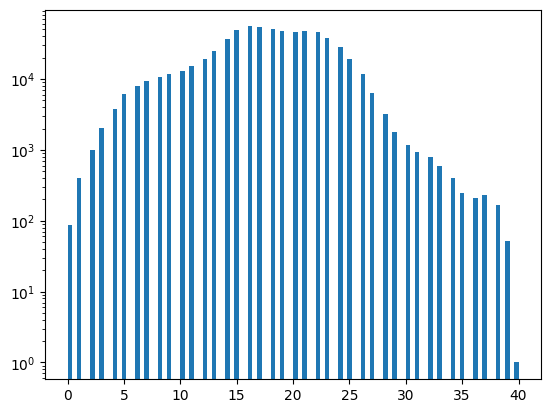

In [10]:
import rbm_torch.utils.data_prep as dp
dp.quick_hist(all_seqs_pd["g_content"].tolist())

In [33]:
from copy import copy
high_gs = copy(all_seqs_pd[all_seqs_pd["g_content"] >= 25])
high_gs.sort_values("g_content", inplace=True, ascending=False)
high_gs.head(50)

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,mean,max,g_content,8G_strait
92899,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,16.0,3.0,2.0,405.0,90.0,10.0,19.0,113.0,195.0,94.777778,405.0,40,True
582235,GCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.000000,1.0,39,True
257787,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGG,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,2.0,1.250000,2.0,39,True
379832,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGGGGGG,NaN,NaN,NaN,2.0,1.0,NaN,NaN,1.0,1.0,1.250000,2.0,39,True
270303,GGGGGGGGCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,NaN,NaN,NaN,12.0,1.0,NaN,NaN,4.0,7.0,6.000000,12.0,39,True
270352,GGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGGGGGGGG,NaN,NaN,NaN,12.0,1.0,NaN,1.0,9.0,4.0,5.400000,12.0,39,True
455047,GGGGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.666667,2.0,39,True
173725,GGGGGGGGGGGGGGGGGGTGGGGGGGGGGGGGGGGGGGGG,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,39,True
626118,GGGGGGGGGGGGGGGGGGGGGCGGGGGGGGGGGGGGGGGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.000000,1.0,39,True
293807,GGGGGGGGGGGGGGGGGGGGGGGGGTGGGGGGGGGGGGGG,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,2.500000,4.0,39,True


In [19]:
get_len(all_seqs_pd[(all_seqs_pd["max"] >= 25) & (all_seqs_pd["g_content"] <= 25)])

32758


In [35]:
from copy import copy

# fasta_id = "m1"
# seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)

max_all = copy(all_seqs_pd[(all_seqs_pd["max"] >= 25) & (all_seqs_pd["g_content"] <= 28) & (all_seqs_pd["8G_strait"] == False)])
max_all["copy_num"] = max_all["max"]
get_len(max_all)

23529


In [36]:
from rbm_torch.utils.seq_utils import prune_similar_sequences
htrimmed = prune_similar_sequences(max_all, hamming_threshold=3, molecule="dna")
amax_seqs = htrimmed.sequence.tolist()
amax_cns = htrimmed.copy_num.tolist()

Kept 7620 of 23529


In [24]:
dp.write_fasta(amax_seqs, amax_cns, "./cov/comp.fasta")

In [27]:
from rbm_torch.utils import utils

fasta_file = "comp.fasta"

seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_file.split('.')[0]}_st", scale="log", dividers=[50], target_scaling=[2.], divider_type="percentile")

dp.make_weight_file("comp_st", stand_affs, dir="./cov/")

# import os
# import subprocess as sp
#
# os.chdir("../rbm_torch/")
# sp.call(f"python submit.py -d cov -r comp -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True)  # weights
# sp.call(f"python submit.py -d cov -r comp -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w comp_st.json --precision single", shell=True)  # weights

Process Time 0.008008241653442383
